In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
import stft
from scipy.signal import blackman
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from time import perf_counter

/Users/georgeoblapenko/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

First, let's load some audio

In [200]:
rate, data = wavfile.read('../audio_examples/Sick_bed.wav')

/Users/georgeoblapenko/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Next, we'll compute a spectrogram of a mono signal (obtained by summing the L & R channels) and using the default (cosine) window function

In [201]:
overlap = 4
framelength = 1024

specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)

We're interested in the absolute values of the spectrogram, and we'll log-scale it

In [202]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
phase = np.angle(specgram)
print(log_spectrogram.shape)

(513, 31077)


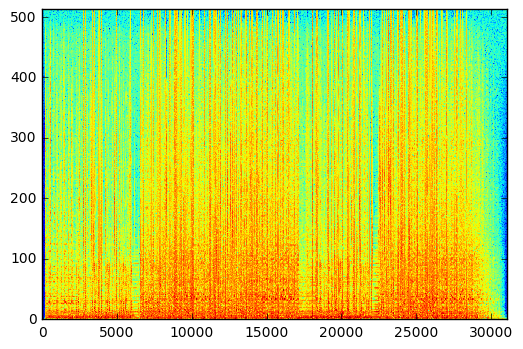

In [203]:
plt.imshow(log_spectrogram, origin='lower', aspect='auto',
           interpolation='nearest')

Now we'll specify for each moment of time `t` which preceding intervals of the form `[t-a,t-b]` we want to use for feature extraction. So if for each interval we have `N` different features, the total amount of different features we'll have is equal to `N * n_intervals`.

We want to have varied information from the audio, so we sample features not for every frame, but each `step_size` frames.

In [212]:
steps = [(-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-50, 0)]
min_offset = max([-(i[0]) for i in steps])
step_size = 10

In [213]:
min_offset

3000

We want to have the frequency content of an interval as a (vector) feature; but we have too many frequency bins, so we just reduce their number by summation of their content.

In [214]:
freq_avg_step = 27
num_freq_bins_reduced = log_spectrogram.shape[0]//freq_avg_step
print(num_freq_bins_reduced)

19


Some feature extraction functions

In [215]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice) / spgram_slice.shape[1]  # gets the average amplitude of the slice

In [216]:
def get_loudest_bin(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1)
    return np.argmax(tmp) / spgram_slice.shape[1]
# returns the index of the loudest frequency bin, the slice is averaged

Now we let's extract the features and the spectral content for each frame

In [217]:
nfeat = 2 * len(steps) + num_freq_bins_reduced
# number of features - we have 2 scalar features for each slice of audio + frequency bins (enlarged) for previous frame

In [218]:
def get_features_for_frame(log_spgram_slice, scalar_functions, n_features):
    res = np.zeros(n_features)
    counter = 0
    for s_f in scalar_functions:
        for slicing in steps:
            res[counter] = s_f(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += 1
    for j in range(num_freq_bins_reduced):
        res[counter + j] = np.sum(log_spgram_slice[j * freq_avg_step:(j+1) * freq_avg_step, -1])
    return res

In [219]:
def process_spectrogram(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features])
    for i in range(n_slices):
        if i%200 == 0:
            print(i)
        loc_Y[i] = log_spgram[:, min_offset + step_size * i]
        loc_X[i, 0:n_features] = get_features_for_frame(log_spgram[:,step_size * i:min_offset
                                                                     + step_size * i], scalar_functions, n_features)
    return [loc_X, loc_Y]

In [220]:
n_samples = 1500

start_time = perf_counter()
X, Y = process_spectrogram(log_spectrogram, [get_avg_amplitude, get_loudest_bin],
                           n_samples, nfeat)
print(perf_counter() - start_time)

0
200
400
600
800
1000
1200
1400
8.113051215999803


Next, we scale the features and the target values

In [221]:
feature_scaler_freq = StandardScaler()
X = feature_scaler_freq.fit_transform(X)

freq_Y_mean = np.mean(Y)
freq_Y_std = np.std(Y)

Y = (Y - freq_Y_mean) / freq_Y_std

Then, we train a linear regression model

In [222]:
predictor = LinearRegression()
predictor.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's then try and generate some new audio (frequency and phase) and compare it with the real audio, to assess the performance of our model. First, we'll take a chunk of the audio that hasn't been fed to our model before, to use a starting point.
At some point, the model will only generate audio based on only newly generated audio.

In [223]:
keep_starting_audio = False  # if False, we cut off the seed audio
gen_start = min_offset + n_samples * step_size
print(gen_start, min_offset)  # the starting point of the seed audio and the length of the seed audio
generate_size = 10000  # how many samples we want to generate
result = np.zeros([log_spectrogram.shape[0], generate_size + min_offset])
result_phase = np.random.rand(log_spectrogram.shape[0], generate_size + min_offset) * 2 * 3.141
feat_arr = np.zeros([1, nfeat])

for i in range(min_offset):
    result[:, i] = log_spectrogram[:, gen_start + i]
max_val = np.max(np.sum(result**2, axis=0)) * 0.4  # to normalize the audio

for i in range(generate_size):
    if i%500 == 0:
        print(i)
    feat_arr[0,:nfeat] = get_features_for_frame(result[:, i:i+min_offset],
                                                [get_avg_amplitude, get_loudest_bin],nfeat)
    result[:, min_offset+i] = predictor.predict(feature_scaler_freq.transform(feat_arr))
    result[:, min_offset+i] *= freq_Y_std  # now we rescale it back
    result[:, min_offset+i] += freq_Y_mean
    if np.sum(result[:, min_offset+i]**2) > max_val:
        result[:, min_offset+i] /= max_val**0.5

18000 3000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [224]:
print(mean_squared_error(result[:, min_offset:],
                         log_spectrogram[:, gen_start + min_offset:gen_start + min_offset + generate_size]))

14.9850844728


In [225]:
result.shape

(513, 13000)

In [226]:
if not keep_starting_audio:
    result = result[:, min_offset:]
    result_phase = result_phase[:, min_offset:]

Let's now generate some audio based on an audio 'seed' (in this case, a chunk of the original waveform).
At some point, the model will only generate audio based on only newly generated audio.

In [227]:
np.max(result), max_val

(14.003996555193567, 28664.52493288157)

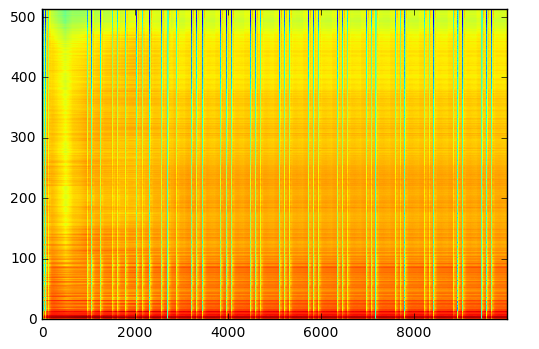

In [228]:
plt.imshow(result, origin='lower', aspect='auto',
           interpolation='nearest')

In [229]:
freq_amplitude = np.exp(result) - 1
result_complex = freq_amplitude * np.exp(1j * result_phase)

In [230]:
audio_dat = stft.ispectrogram(result_complex, framelength=framelength, overlap=overlap)

In [231]:
def write_stereo(a_l, a_r, s_r, name):
    a_s = np.zeros([a_l.shape[0], 2], dtype=np.int16)
    a_s[:, 0] = a_l
    a_s[:, 1] = a_r
    print(a_s.shape)
    wavfile.write(name, s_r, a_s)

In [232]:
write_stereo(audio_dat, audio_dat, 44100, 'sick.wav')

(2559744, 2)
